In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
from matplotlib.patches import Patch
from skimage.draw import polygon2mask

# --- (Re-using load_dicom_series_to_hu from previous responses) ---
def load_dicom_series_to_hu(dicom_dir):
    slices = []
    for s in os.listdir(dicom_dir):
        try:
            filepath = os.path.join(dicom_dir, s)
            ds = pydicom.dcmread(filepath)
            if ds.SOPClassUID == '1.2.840.10008.5.1.4.1.1.2' and 'PixelData' in ds:
                slices.append(ds)
        except Exception:
            continue
    if not slices:
        print(f"No valid CT DICOM images found in {dicom_dir}")
        return None, None
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    pixel_spacing = slices[0].PixelSpacing
    slice_thickness = float(slices[0].SliceThickness)
    spacing_between_slices = getattr(slices[0], 'SpacingBetweenSlices', slice_thickness)
    image_position_patient = np.array(slices[0].ImagePositionPatient)
    origin_3d = image_position_patient
    spacing_3d = np.array([pixel_spacing[1], pixel_spacing[0], spacing_between_slices])
    image_3d_shape = (len(slices), slices[0].Rows, slices[0].Columns)
    image_3d_hu = np.zeros(image_3d_shape, dtype=np.int16)
    for i, s in enumerate(slices):
        raw_pixel_array = s.pixel_array
        rescale_slope = getattr(s, 'RescaleSlope', 1)
        rescale_intercept = getattr(s, 'RescaleIntercept', 0)
        hu_array = raw_pixel_array * rescale_slope + rescale_intercept
        image_3d_hu[i, :, :] = hu_array
    slice_z_positions = np.array([float(s.ImagePositionPatient[2]) for s in slices])
    return image_3d_hu, {
        'origin': origin_3d,
        'spacing': spacing_3d,
        'shape': image_3d_hu.shape,
        'slice_z_positions': slice_z_positions,
        'slice_thickness': slice_thickness
    }

In [2]:
def get_dark_artifact_hu_values_from_slice(
    current_slice,
    metal_hu_threshold,
    artifact_roi_margin_pixels,
    dark_artifact_hu_range
):
    """
    Identifies dark artifact pixels within an automatically defined ROI around metal
    on a given 2D CT slice and extracts their HU values.

    Args:
        current_slice (np.ndarray): The 2D NumPy array of a CT slice in Hounsfield Units.
        metal_hu_threshold (int): HU value to segment the metal implant.
        artifact_roi_margin_pixels (int): How many pixels to expand around the metal bounding box.
        dark_artifact_hu_range (tuple): (min_hu, max_hu) defining the HU range for dark artifacts.

    Returns:
        tuple: (dark_artifact_hu_values, final_artifact_mask, metal_mask, artifact_roi_coords).
               dark_artifact_hu_values is a 1D array of HU values of the artifacts.
               final_artifact_mask is a 2D boolean mask of the artifact region.
               metal_mask is a 2D boolean mask of the detected metal.
               artifact_roi_coords is a tuple (r_min, r_max, c_min, c_max) of the calculated ROI.
               Returns (np.array([]), None, None, None) if no metal is found.
    """
    rows, cols = current_slice.shape
    
    # 1. Identify the metal implant
    metal_mask = current_slice > metal_hu_threshold

    if not np.any(metal_mask):
        print(f"No metal detected on slice with threshold {metal_hu_threshold} HU. Cannot define ROI around metal.")
        return np.array([]), None, None, None

    # 2. Find bounding box of the metal
    r_coords, c_coords = np.where(metal_mask)
    r_min_metal, r_max_metal = np.min(r_coords), np.max(r_coords)
    c_min_metal, c_max_metal = np.min(c_coords), np.max(c_coords)

    # 3. Define the arbitrary ROI around the metal by adding a margin
    r_min_roi = max(0, r_min_metal - artifact_roi_margin_pixels)
    r_max_roi = min(rows, r_max_metal + artifact_roi_margin_pixels)
    c_min_roi = max(0, c_min_metal - artifact_roi_margin_pixels)
    c_max_roi = min(cols, c_max_metal + artifact_roi_margin_pixels)

    # Create the rectangular arbitrary ROI mask
    arbitrary_roi_mask = np.zeros(current_slice.shape, dtype=bool)
    arbitrary_roi_mask[r_min_roi:r_max_roi, c_min_roi:c_max_roi] = True
    print(f"Defined artifact ROI around metal: rows {r_min_roi}-{r_max_roi}, cols {c_min_roi}-{c_max_roi}")

    # 4. Create a mask for the specified HU range (dark artifacts)
    min_hu, max_hu = dark_artifact_hu_range
    dark_artifact_hu_mask = (current_slice >= min_hu) & (current_slice <= max_hu)

    # 5. Combine masks: only show dark artifacts WITHIN the automatically defined ROI
    final_artifact_mask = dark_artifact_hu_mask & arbitrary_roi_mask

    # Extract HU values from the identified dark artifacts
    dark_artifact_hu_values = current_slice[final_artifact_mask]
    if dark_artifact_hu_values.size == 0:
        print("No dark artifact pixels found in the defined ROI and HU range.")
    else:
        print(f"Extracted {dark_artifact_hu_values.size} dark artifact pixels.")
    
    return dark_artifact_hu_values, final_artifact_mask, metal_mask, (r_min_roi, r_max_roi, c_min_roi, c_max_roi)


# --- Modified Visualization Function ---
def visualize_dark_artifacts_around_metal(
    ct_hu_volume,
    slice_index,
    metal_hu_threshold,
    artifact_roi_margin_pixels,
    dark_artifact_hu_range
):
    """
    Visually displays dark artifacts within an automatically defined ROI around metal implant
    on a given CT slice by calling get_dark_artifact_hu_values_from_slice.
    """
    if slice_index < 0 or slice_index >= ct_hu_volume.shape[0]:
        print(f"Error: Slice index {slice_index} is out of bounds for volume with {ct_hu_volume.shape[0]} slices.")
        return

    current_slice = ct_hu_volume[slice_index, :, :]
    
    # Call the new function to get the data and masks
    extracted_hu_values, final_artifact_mask, metal_mask, roi_coords = \
        get_dark_artifact_hu_values_from_slice(
            current_slice,
            metal_hu_threshold,
            artifact_roi_margin_pixels,
            dark_artifact_hu_range
        )
    
    # If no mask was generated (e.g., no metal found), just return
    if final_artifact_mask is None:
        return

    # --- Visualization (unchanged from previous version, but uses new function's outputs) ---
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
    ax1.set_title(f"Original CT Slice {slice_index} (Windowed)")
    ax1.axis('off')

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
    
    # Depicts metal implant
    masked_metal = np.ma.masked_where(~metal_mask, metal_mask)
    ax2.imshow(masked_metal, cmap='hot', alpha=0.7)

    # Depicts dark artifacts within the automatically defined ROI
    masked_artifacts = np.ma.masked_where(~final_artifact_mask, final_artifact_mask)
    ax2.imshow(masked_artifacts, cmap='winter', alpha=0.6)

    # Draw the automatically defined ROI boundary
    if roi_coords:
        r_min_roi, r_max_roi, c_min_roi, c_max_roi = roi_coords
        ax2.add_patch(plt.Rectangle((c_min_roi, r_min_roi), c_max_roi-c_min_roi, r_max_roi-r_min_roi,
                                    edgecolor='blue', facecolor='none', linewidth=2, linestyle='--', label='Auto ROI Around Metal'))
        ax2.legend(loc='lower right')
    
    ax2.set_title(f"Dark Artifacts around Metal (Slice {slice_index})")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def visualize_artifacts(
    ct_hu_volume,
    slice_index,
    metal_hu_treshold,
    bright_artirfact_hu_range,
    bone_hu_range,
    dark_artifact_hu_range,
    artifact_roi_margin_pixels
):
    """
    Identifies and displays metal, bone, dark and bright arficats in the given CT slice. Artifacts are constrained to an ROI around the metal implant.
    """
    if slice_index < 0 or slice_index >= ct_hu_volume.shape[0]:
        print(f"Error: Slice index {slice_index} is out of bounds for volume with {ct_hu_volume.shape[0]} slices.")
        return
    
    # Current slice extraction. Takes a 2D slice and its respective x and y dimensions.
    current_slice = ct_hu_volume[slice_index, :, :] 
    rows, cols = current_slice.shape

    # --- Characterization Logic ---

    # 1. Identify the metal implant(s)
    # Starting point for defining the ROI. If current slice is bigger than the threshold, is an array of HU values above the threshold.
    metal_mask = current_slice > metal_hu_threshold

    if not np.any(metal_mask):
        print(f"No metal detected on slice with threshold {metal_hu_threshold} HU. Cannot define ROI around metal.")
        # Display original slice if no metal is found
        plt.figure(figsize=(6, 6))
        plt.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
        plt.title(f"Original CT Slice {slice_index} (No Metal Detected)")
        plt.axis('off')
        plt.show()
        return
    
    

Loading CT series from: C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT
CT Volume loaded with shape: (248, 512, 512)

Extracting dark artifacts for slice 124 with auto-ROI around metal...
Defined artifact ROI around metal: rows 193-305, cols 103-212
Extracted 263 dark artifact pixels.

Successfully extracted 263 HU values for dark artifacts.
Min HU of dark artifacts: -998
Max HU of dark artifacts: -251
Mean HU of dark artifacts: -391.87


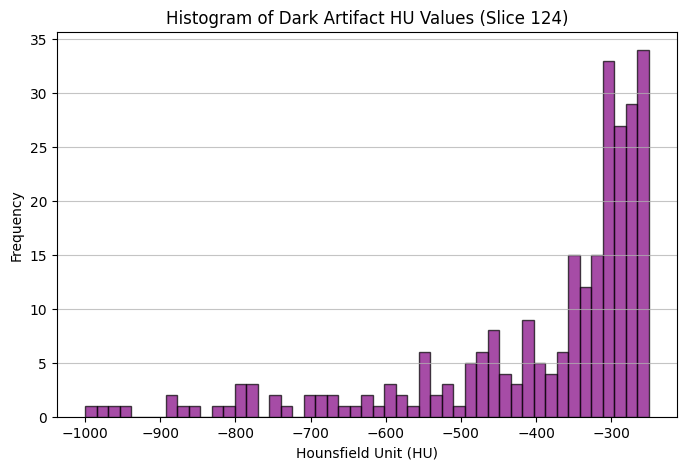


Visualizing the results (optional)...
Defined artifact ROI around metal: rows 193-305, cols 103-212
Extracted 263 dark artifact pixels.


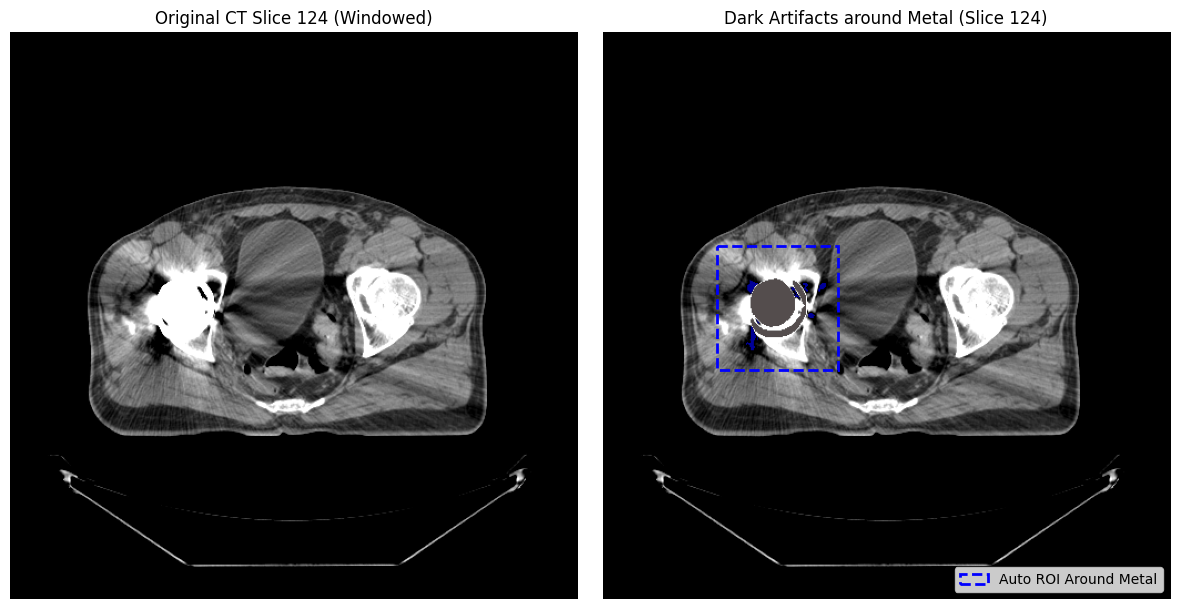

In [4]:
# --- Main Execution Example ---
if __name__ == "__main__":
    ct_series_directory = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"

    if not os.path.isdir(ct_series_directory):
        print(f"Error: CT series directory not found at '{ct_series_directory}'. Please update the path.")
    else:
        print(f"Loading CT series from: {ct_series_directory}")
        ct_hu_volume, ct_spatial_meta = load_dicom_series_to_hu(ct_series_directory)

        if ct_hu_volume is None:
            print("Failed to load CT volume. Exiting.")
        else:
            print(f"CT Volume loaded with shape: {ct_hu_volume.shape}")

            slice_to_analyze = ct_hu_volume.shape[0] // 2 

            metal_hu_threshold_val = 1500
            artifact_margin_pixels = 30 
            dark_artifact_range = (-1000, -250) 

            # --- Call the new extraction function directly ---
            print(f"\nExtracting dark artifacts for slice {slice_to_analyze} with auto-ROI around metal...")
            extracted_dark_artifact_hu, dark_artifact_mask_2d, metal_mask_2d, roi_coords_2d = \
                get_dark_artifact_hu_values_from_slice(
                    ct_hu_volume[slice_to_analyze, :, :], # Pass the specific slice
                    metal_hu_threshold=metal_hu_threshold_val,
                    artifact_roi_margin_pixels=artifact_margin_pixels,
                    dark_artifact_hu_range=dark_artifact_range
                )
            
            # --- Now you have the HU values and masks separately ---
            if extracted_dark_artifact_hu.size > 0:
                print(f"\nSuccessfully extracted {extracted_dark_artifact_hu.size} HU values for dark artifacts.")
                print(f"Min HU of dark artifacts: {extracted_dark_artifact_hu.min()}")
                print(f"Max HU of dark artifacts: {extracted_dark_artifact_hu.max()}")
                print(f"Mean HU of dark artifacts: {extracted_dark_artifact_hu.mean():.2f}")

                # You can now plot a histogram of JUST these dark artifact HU values
                plt.figure(figsize=(8, 5))
                plt.hist(extracted_dark_artifact_hu, bins=np.linspace(dark_artifact_range[0], dark_artifact_range[1], 50),
                         color='purple', edgecolor='black', alpha=0.7)
                plt.title(f"Histogram of Dark Artifact HU Values (Slice {slice_to_analyze})")
                plt.xlabel('Hounsfield Unit (HU)')
                plt.ylabel('Frequency')
                plt.grid(axis='y', alpha=0.75)
                plt.show()
            else:
                print("No dark artifact HU values were extracted for histogram generation.")

            # --- You can still call the visualization function if you want to see the overlay ---
            print("\nVisualizing the results (optional)...")
            visualize_dark_artifacts_around_metal(
                ct_hu_volume,
                slice_to_analyze,
                metal_hu_threshold=metal_hu_threshold_val,
                artifact_roi_margin_pixels=artifact_margin_pixels,
                dark_artifact_hu_range=dark_artifact_range
            )

Loading CT series from: C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT
CT Volume loaded with shape: (248, 512, 512)

Visualizing and characterizing regions for slice 124...
Defined artifact ROI around metal: rows 194-305, cols 104-212
Dark Artifacts found: Count=648, Min HU=-998.00, Max HU=-150.00

--- Characterizing Bright Artifacts ---
  Step 1.1 (Raw HU range 1000-2500): 473 pixels identified.
  Step 1.2 (Raw HU range 4000-6000): 1051 pixels identified.
  Step 2 (Within ROI): 1494 pixels identified.
  Step 3 (Excluding Metal): 443 pixels finally identified as Bright Artifacts.
Bright Artifacts found: Count=443, Min HU=1007.00, Max HU=2497.00
Bone found: Count=1175, Min HU=300.00, Max HU=999.00


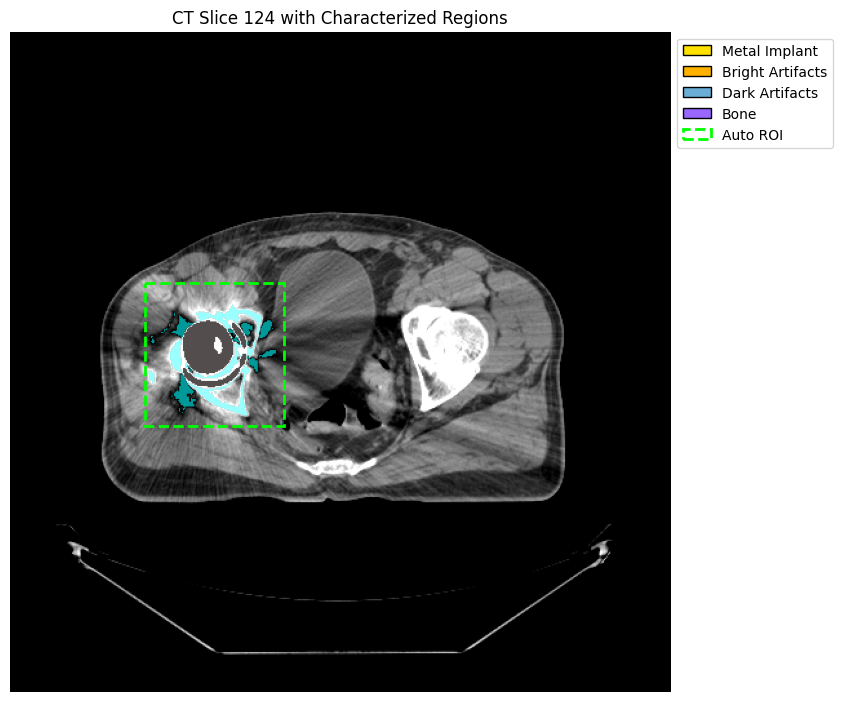

In [5]:
def visualize_implant_artifacts_and_tissues(
    ct_hu_volume,
    slice_index,
    metal_hu_threshold=2500, # Very high threshold for pure metal
    # CHANGED: Now a list of tuples for bright artifact HU ranges
    bright_artifact_hu_ranges=[(1000, 2500)], 
    bone_hu_range=(100, 1000), # General bone range
    dark_artifact_hu_range=(-1000, -250),
    artifact_roi_margin_pixels=75 # Margin around metal for artifact ROI
):
    """
    Identifies and visually displays metal, bright artifacts, bone, and dark artifacts
    on a given CT slice. Artifacts are constrained to an ROI around metal.

    Args:
        ct_hu_volume (np.ndarray): The 3D NumPy array of CT scan in Hounsfield Units.
        slice_index (int): The index of the 2D slice to display (0-based).
        metal_hu_threshold (int): HU value to segment the core metal implant.
        bright_artifact_hu_ranges (list of tuples): List of (min_hu, max_hu) tuples for bright artifacts.
        bone_hu_range (tuple): (min_hu, max_hu) for bone.
        dark_artifact_hu_range (tuple): (min_hu, max_hu) for dark artifacts.
        artifact_roi_margin_pixels (int): Margin in pixels to expand around the metal bounding box.
    """
    if slice_index < 0 or slice_index >= ct_hu_volume.shape[0]:
        print(f"Error: Slice index {slice_index} is out of bounds for volume with {ct_hu_volume.shape[0]} slices.")
        return

    current_slice = ct_hu_volume[slice_index, :, :]
    rows, cols = current_slice.shape
    
    # --- Characterization Logic ---

    # 1. Identify the core metal implant
    metal_mask = current_slice > metal_hu_threshold

    if not np.any(metal_mask):
        print(f"No metal detected on slice {slice_index} with threshold {metal_hu_threshold} HU. "
              "Cannot define artifact ROI and proceed with detailed characterization.")
        plt.figure(figsize=(6,6))
        plt.imshow(current_slice, cmap='gray', vmin=-150, vmax=250)
        plt.title(f"CT Slice {slice_index} (No Metal or Overlays)")
        plt.axis('off')
        plt.show()
        return

    # Find bounding box of the metal to define the ROI around it
    r_coords, c_coords = np.where(metal_mask)
    r_min_metal, r_max_metal = np.min(r_coords), np.max(r_coords)
    c_min_metal, c_max_metal = np.min(c_coords), np.max(c_coords)

    # Define the ROI around the metal by adding a margin
    r_min_roi = max(0, r_min_metal - artifact_roi_margin_pixels)
    r_max_roi = min(rows, r_max_metal + artifact_roi_margin_pixels)
    c_min_roi = max(0, c_min_metal - artifact_roi_margin_pixels)
    c_max_roi = min(cols, c_max_metal + artifact_roi_margin_pixels)
    
    artifact_roi_mask = np.zeros(current_slice.shape, dtype=bool)
    artifact_roi_mask[r_min_roi:r_max_roi, c_min_roi:c_max_roi] = True
    print(f"Defined artifact ROI around metal: rows {r_min_roi}-{r_max_roi}, cols {c_min_roi}-{c_max_roi}")

    # 2. Characterize Dark Artifacts (within the artifact_roi_mask)
    min_hu_dark, max_hu_dark = dark_artifact_hu_range
    dark_artifact_hu_mask_raw = (current_slice >= min_hu_dark) & (current_slice <= max_hu_dark)
    final_dark_artifact_mask = dark_artifact_hu_mask_raw & artifact_roi_mask
    if np.any(final_dark_artifact_mask):
        dark_artifact_hu_values = current_slice[final_dark_artifact_mask]
        print(f"Dark Artifacts found: Count={dark_artifact_hu_values.size}, Min HU={dark_artifact_hu_values.min():.2f}, Max HU={dark_artifact_hu_values.max():.2f}")
    else:
        print("No dark artifact pixels found in the defined ROI and HU range.")

    # 3. Characterize Bright Artifacts (within the artifact_roi_mask, EXCLUDING metal)
    print("\n--- Characterizing Bright Artifacts ---")
    bright_artifact_hu_mask_combined = np.zeros_like(current_slice, dtype=bool)
    for i, (min_hu_bright, max_hu_bright) in enumerate(bright_artifact_hu_ranges):
        # Step 1: Initial HU range selection for potentially bright artifact pixels
        bright_artifact_hu_mask_range = (current_slice >= min_hu_bright) & (current_slice <= max_hu_bright)
        bright_artifact_hu_mask_combined |= bright_artifact_hu_mask_range # Combine with OR
        print(f"  Step 1.{(i+1)} (Raw HU range {min_hu_bright}-{max_hu_bright}): {np.sum(bright_artifact_hu_mask_range)} pixels identified.")
    
    # Step 2: Confine to the region of interest (ROI) around the metal
    bright_artifact_in_roi_mask = bright_artifact_hu_mask_combined & artifact_roi_mask
    print(f"  Step 2 (Within ROI): {np.sum(bright_artifact_in_roi_mask)} pixels identified.")

    # Step 3: Exclude pixels that are actually part of the metal implant itself
    final_bright_artifact_mask = bright_artifact_in_roi_mask & ~metal_mask
    print(f"  Step 3 (Excluding Metal): {np.sum(final_bright_artifact_mask)} pixels finally identified as Bright Artifacts.")

    if np.any(final_bright_artifact_mask):
        bright_artifact_hu_values = current_slice[final_bright_artifact_mask]
        print(f"Bright Artifacts found: Count={bright_artifact_hu_values.size}, Min HU={bright_artifact_hu_values.min():.2f}, Max HU={bright_artifact_hu_values.max():.2f}")
    else:
        print("No bright artifact pixels found after all filtering.")

    # 4. Characterize Bone (within the artifact_roi_mask, EXCLUDING metal and bright artifacts)
    min_hu_bone, max_hu_bone = bone_hu_range
    bone_hu_mask_raw = (current_slice >= min_hu_bone) & (current_slice <= max_hu_bone)
    final_bone_mask = bone_hu_mask_raw & artifact_roi_mask & ~metal_mask & ~final_bright_artifact_mask
    if np.any(final_bone_mask):
        bone_hu_values = current_slice[final_bone_mask]
        print(f"Bone found: Count={bone_hu_values.size}, Min HU={bone_hu_values.min():.2f}, Max HU={bone_hu_values.max():.2f}")
    else:
        print("No bone pixels found in the defined ROI and HU range.")
    
    # --- Visualization ---
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    ax.imshow(current_slice, cmap='gray', vmin=-150, vmax=250) 
    ax.set_title(f"CT Slice {slice_index} with Characterized Regions")
    ax.axis('off')

    # Define colors and alphas for consistency
    metal_color = plt.cm.hot(0.7) 
    bright_artifact_color = plt.cm.Wistia(0.6) 
    bone_color = plt.cm.Blues(0.5) 
    dark_artifact_color = plt.cm.cool(0.6) 
    roi_boundary_color = 'lime' 

    # Overlay Metal 
    if np.any(metal_mask):
        masked_metal = np.ma.masked_where(~metal_mask, metal_mask)
        ax.imshow(masked_metal, cmap=plt.cm.hot, alpha=0.7) 

    # Overlay Bright Artifacts 
    # if np.any(final_bright_artifact_mask):
    #     masked_bright = np.ma.masked_where(~final_bright_artifact_mask, final_bright_artifact_mask)
    #     ax.imshow(masked_bright, cmap=plt.cm.Wistia, alpha=0.5)

    # Overlay Bone 
    if np.any(final_bone_mask):
        masked_bone = np.ma.masked_where(~final_bone_mask, final_bone_mask)
        ax.imshow(masked_bone, cmap=plt.cm.cool, alpha=0.4)

    # Overlay Dark Artifacts 
    if np.any(final_dark_artifact_mask):
        masked_dark = np.ma.masked_where(~final_dark_artifact_mask, final_dark_artifact_mask)
        ax.imshow(masked_dark, cmap=plt.cm.cool, alpha=0.6)

    # Draw the automatically defined ROI boundary
    if artifact_roi_mask is not None: 
        ax.add_patch(plt.Rectangle((c_min_roi, r_min_roi), c_max_roi-c_min_roi, r_max_roi-r_min_roi,
                                    edgecolor=roi_boundary_color, facecolor='none', linewidth=2, linestyle='--', label='Auto ROI'))
    
    # Create custom legend handles for the overlays
    legend_elements = [
        Patch(facecolor=metal_color, edgecolor='black', label='Metal Implant'),
        Patch(facecolor=bright_artifact_color, edgecolor='black', label='Bright Artifacts'),
        Patch(facecolor=bone_color, edgecolor='black', label='Dark Artifacts'),
        Patch(facecolor=dark_artifact_color, edgecolor='black', label='Bone')
    ]
    if artifact_roi_mask is not None:
        legend_elements.append(Patch(facecolor='none', edgecolor=roi_boundary_color, lw=2, ls='--', label='Auto ROI'))

    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

if __name__ == "__main__":
    ct_series_directory = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 CT"
    
    rtstruct_file_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\HIP4 Patient\HIP4 RSTRUCT\2.16.840.1.114362.1.12177026.23360333229.708561731.777.13.dcm" 

    if not os.path.isdir(ct_series_directory):
        print(f"Error: CT series directory not found at '{ct_series_directory}'. Please update the path.")
    else:
        print(f"Loading CT series from: {ct_series_directory}")
        ct_hu_volume, ct_spatial_meta = load_dicom_series_to_hu(ct_series_directory)

        if ct_hu_volume is None:
            print("Failed to load CT volume. Exiting.")
        else:
            print(f"CT Volume loaded with shape: {ct_hu_volume.shape}")

            slice_to_analyze = ct_hu_volume.shape[0] // 2

            # --- Define your HU thresholds/ranges ---
            metal_thresh = 2500 
            # CHANGED: bright_artifact_hu_range_vals is now a list of tuples
            bright_artifact_range_vals = [(1000, 2500), (4000, 6000)] # Example: two ranges for bright artifacts
            bone_range_vals = (300, 1300) 
            dark_artifact_range_vals = (-1000, -150) 
            artifact_margin_pixels_val = 30

            print(f"\nVisualizing and characterizing regions for slice {slice_to_analyze}...")
            visualize_implant_artifacts_and_tissues(
                ct_hu_volume,
                slice_to_analyze,
                metal_hu_threshold=metal_thresh,
                bright_artifact_hu_ranges=bright_artifact_range_vals, # Note the plural 'ranges' here
                bone_hu_range=bone_range_vals,
                dark_artifact_hu_range=dark_artifact_range_vals,
                artifact_roi_margin_pixels=artifact_margin_pixels_val
            )